In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from statistics_kit import *

import serial
import time

# Set up the serial connection
ser = serial.Serial('/dev/ttyACM4', 115200)  # Adjust the baud rate if necessary
time.sleep(.1)  # Wait for the connection to establish


def ask(cmd):
    ser.reset_input_buffer()
    ser.write(f"{cmd}\n".encode())  # Send the number followed by a newline
    time.sleep(.01)  # Wait for a second before sending the next number
    line = ser.readline().decode()
    line = line.replace("\r","")
    line = line.replace("\n","")
    #print("readback: ",end="")
    return line


m = 1024
y0 = 0


def read_adc(**kwargs):
    ch = kwargs.get("ch",0)
    ans = ask("ADC={:d}".format(ch))
    return int(ans)

def r_fpga_reg(n):
    cmd="FPGA=01{:02x}{:04x}".format(n,0);
    ans = ask(cmd)
    return int(ans[4:],16)

def w_fpga_reg(n,val):
    cmd="FPGA=02{:02x}{:04x}".format(n,val);
    return ask(cmd)

def w_fpga_reg_bit(n,b,state):
    cur_val = r_fpga_reg(n)
    new_val = (cur_val & ~(1<<b)) | (state*(1<<b))
    w_fpga_reg(n, new_val)
    
def set_loop_length(n):
    w_fpga_reg(2, n)
    
def get_loop_length():
    return r_fpga_reg(2)
    
def enable_stop(state):
    w_fpga_reg_bit(3,0,state)
    
def enable_start(state):
    w_fpga_reg_bit(3,2,state)
    
def enable_trig(state):
    w_fpga_reg_bit(3,3,state)
    
def enable_mask(state):
    w_fpga_reg_bit(3,1,state)
    
def set_thr_start(val):
    w_fpga_reg(0,int(val))
    
def set_thr_stop(val):
    w_fpga_reg(1,int(val))
    
def set_mask_time(val):
    w_fpga_reg(4,int(val))
    
def set_start_time(val):
    w_fpga_reg(5,int(val))
    
def set_start_hold_time(val):
    w_fpga_reg(7,int(val))
    
def set_stop_time(val):
    w_fpga_reg(6,int(val))
    
def read_calib_adc():
    return (read_adc(ch=0)-y0)/m
    
#ser.close()

read_adc()

779

In [2]:
get_loop_length()

4

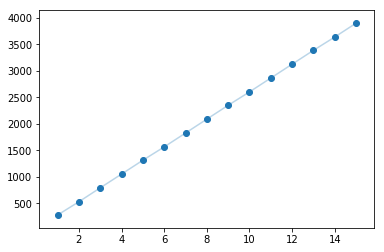

regression parameters: m, y0
4136.285714285715
18.790476190476056


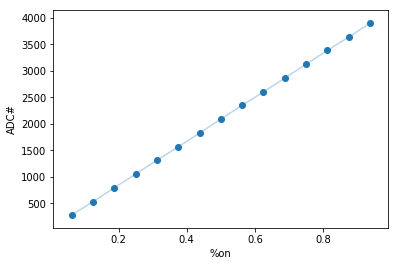

In [3]:
##################################################
##          calibrate ADC with MASK             ##
##################################################


steps = 16

enable_stop(0)
enable_start(0)
enable_mask(1)
set_loop_length(steps)
set_mask_time(8)
set_start_time(0)
set_stop_time(0)
set_thr_start(10e3)
set_thr_stop(10e3)

x = np.array([])
avals = np.array([])


for i in range(1,steps):

    set_mask_time(i)
    x = np.append(x,[i])
    time.sleep(.1)
    avals = np.append(avals,[read_adc(ch=0)])

    
plt.plot(x,avals,alpha=0.3)
plt.scatter(x,avals)

plt.show()

p=x/steps
plt.plot(p,avals,alpha=0.3)
plt.scatter(p,avals)
plt.xlabel("%on")
plt.ylabel("ADC#")
print("regression parameters: m, y0")
m,y0 = pearson_regression(p,avals)
print(m)
print(y0)

In [39]:
from ipywidgets import interact

enable_trig(1)

def my_function(loop_length=4, thr_start=10000, thr_stop=20000,mask_time=2,
                start_time=0,start_hold_time=0, stop_time=0,
                en_start=True, en_stop=False, en_mask=False):
    
    enable_stop(en_stop)
    enable_start(en_start)
    enable_mask(en_mask)
    set_loop_length(loop_length)
    set_mask_time(mask_time)
    set_start_time(start_time)
    set_start_hold_time(start_hold_time)
    set_stop_time(stop_time)
    #start = 30000
    set_thr_start(thr_start)
    set_thr_stop(thr_stop)
    #time.sleep(0.1)
    print("ADC: {:d}".format(read_adc(ch=0)))
    print("calibADC: {:3.3f}".format(read_calib_adc()))

    
# create a slider
interact(my_function, loop_length=(0,10,1),
         thr_start=(10000,50000,100),
         thr_stop=(10000,50000,100),en_stop=False,en_mask=True,
        mask_time=(0,10,1),
        start_time=(0,10,1),
        start_hold_time=(0,10,1),
        stop_time=(0,10,1),
         en_start=True)

interactive(children=(IntSlider(value=4, description='loop_length', max=10), IntSlider(value=10000, descriptio…

<function __main__.my_function(loop_length=4, thr_start=10000, thr_stop=20000, mask_time=2, start_time=0, start_hold_time=0, stop_time=0, en_start=True, en_stop=False, en_mask=False)>

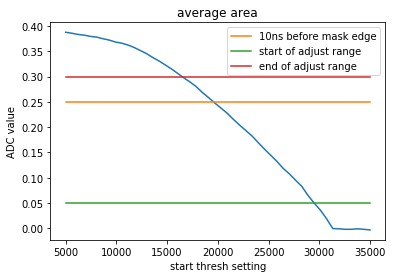

In [4]:
adc_vals = []
thr_vals = []


# goal is to bridge one clock period, i.e. 25% of a 4 clock cycle
# with a thr_start of circa 18000 we reach that
# or alternatively between the adc fraction of 5% and 30%
    

enable_stop(0)
enable_start(1)
enable_mask(1)
set_loop_length(4)
set_mask_time(2)
set_start_time(0)
set_stop_time(0)
set_thr_start(10e3)
set_thr_stop(10e3)

    

for thr_start in np.linspace(5e3,35e3,50):
    set_thr_start(thr_start)
    time.sleep(0.05)
    adc_vals += [read_calib_adc()]
    thr_vals += [int(thr_start)]
    
adc_vals = np.array(adc_vals)
thr_vals = np.array(thr_vals)
    
plt.plot(thr_vals, adc_vals)
plt.plot(thr_vals, thr_vals*0+.25,label="10ns before mask edge")
plt.plot(thr_vals, thr_vals*0+.05,label="start of adjust range")
plt.plot(thr_vals, thr_vals*0+.30,label="end of adjust range")
plt.xlabel("start thresh setting")
plt.ylabel("ADC value")
plt.title("average area")
plt.legend()


(-1.9121103071158642e-05, 0.6240659066307014)


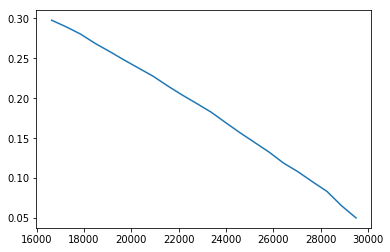

In [5]:
# first degree linear model

xdata = thr_vals
ydata = adc_vals

mask = (ydata >= .05) * (ydata <= .30)
xdata = xdata[mask]
ydata = ydata[mask]

plt.plot(xdata,ydata)
print(pearson_regression(xdata,ydata))

In [5]:
def set_LE_frac(frac,**kwargs):
    
    do_plot = kwargs.get("plot",False)
    
    # integral regulator constant
    ci = 20000
    
    
    # linear starting estimation from previous linear fit
    thr_start = (frac-0.58)/(-1.84e-5)
    
    enable_stop(0)
    enable_start(1)
    enable_mask(1)
    set_loop_length(4)
    set_mask_time(2)
    set_start_time(0)
    set_start_hold_time(0)
    set_stop_time(0)
    set_thr_start(thr_start)
    set_thr_stop(10e3)

    adc_vals = np.array([])

    for i in range(20):
        set_thr_start(thr_start)
        time.sleep(0.02)
        aval = read_calib_adc()
        error = aval-frac
        thr_start += ci*error
        adc_vals = np.append(adc_vals,[aval])
        
    if do_plot:
        plt.plot(adc_vals)
        plt.show()



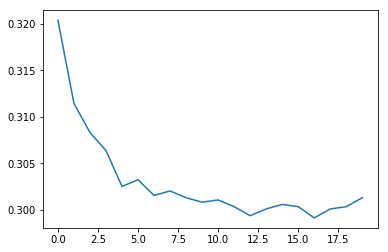

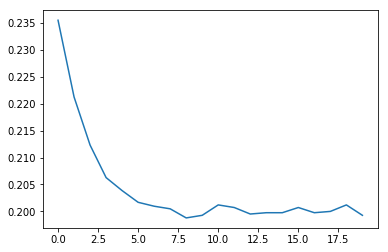

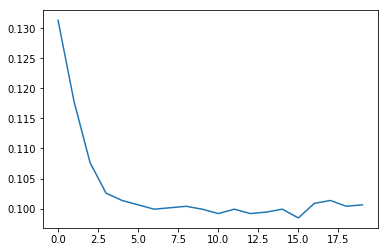

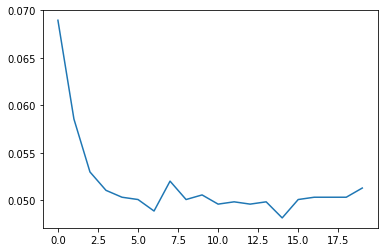

In [6]:

set_LE_frac(0.3, plot=True)
set_LE_frac(0.2, plot=True)
set_LE_frac(0.1, plot=True)
set_LE_frac(0.05, plot=True)

In [40]:
def set_width_frac(frac,**kwargs):
    
    do_plot = kwargs.get("plot",False)
    next_cycle = kwargs.get("next_cycle",False)
    
    
    # integral regulator constant
    ci = -15000
    
    
    # linear starting estimation from previous linear fit
    #thr_start = (frac-0.58)/(-1.84e-5)
    
    thr_stop = 35000
    
    stop_time = 0
    if next_cycle:
        print("doing the next_cycle thing!")
        thr_stop = 20000
        stop_time = 1
    
    enable_stop(1)
    enable_start(1)
    enable_mask(0)
    set_loop_length(4)
    set_mask_time(2)
    set_start_time(0)
    set_start_hold_time(stop_time)
    set_stop_time(stop_time)
    #set_thr_start(thr_start)
    set_thr_stop(thr_stop)

    adc_vals = np.array([])

    for i in range(40):
        set_thr_stop(thr_stop)
        time.sleep(0.02)
        aval = read_calib_adc()
        error = aval-frac
        thr_stop += ci*error
        adc_vals = np.append(adc_vals,[aval])
        
    if do_plot:
        plt.plot(adc_vals)
        plt.show()



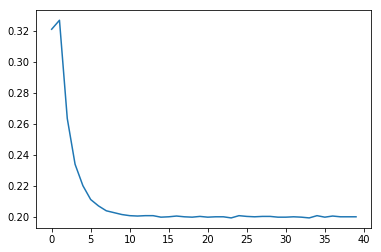

In [8]:
set_LE_frac(0.2)
set_width_frac(0.2,plot=True)

In [9]:
def set_LE_ftime_ns(t):
    zero_frac = 0.065
    period = 40. # ns ,a 4 clk calib circle
    target_frac = t/period + zero_frac
    
    set_LE_frac(target_frac)
    
def set_width_ftime_ns(t,**kwargs):
    period = 40. # ns ,a 4 clk calib circle
    target_frac = t/period 
    
    set_width_frac(target_frac,**kwargs)

In [42]:
def set_pulse_ns(time,width,loop_length):
    
    enable_trig(0)
    
    clk_period = 10
    
    start_time = int( time / clk_period)
    LE_ftime = clk_period-(time % clk_period)
    
    stop_time = start_time + int(width/clk_period)
    
    
    width_ftime = width % clk_period
   
    next_cycle = False
    if (LE_ftime < 5) and (width_ftime > 5):
        stop_time += 1
        next_cycle = True
    
    start_hold_time = stop_time
    
        
    
    print("start time: {}".format(start_time))
    print("LE_ftime: {}".format(LE_ftime))
    print("stop time: {}".format(stop_time))
    print("width_ftime: {}".format(width_ftime))
    set_LE_ftime_ns(LE_ftime)
    set_width_ftime_ns(width_ftime,plot=False,next_cycle=next_cycle)
    
    
    set_start_time(start_time)
    set_start_hold_time(start_hold_time)
    set_stop_time(stop_time)
    set_loop_length(loop_length)
    
    enable_trig(1)
    

In [43]:
set_pulse_ns(9,9.5,10)

start time: 0
LE_ftime: 1
stop time: 1
width_ftime: 9.5
doing the next_cycle thing!


In [34]:
# combi scan 

for t in np.arange(4,12,1):
    set_pulse_ns(t,9.5,10)
    time.sleep(1)
enable_trig(0)

start time: 0
LE_ftime: 6
stop time: 0
width_ftime: 9.5
start time: 0
LE_ftime: 5
stop time: 0
width_ftime: 9.5
start time: 0
LE_ftime: 4
stop time: 1
width_ftime: 9.5
doing the next_cycle thing!
start time: 0
LE_ftime: 3
stop time: 1
width_ftime: 9.5
doing the next_cycle thing!
start time: 0
LE_ftime: 2
stop time: 1
width_ftime: 9.5
doing the next_cycle thing!
start time: 0
LE_ftime: 1
stop time: 1
width_ftime: 9.5
doing the next_cycle thing!
start time: 1
LE_ftime: 10
stop time: 1
width_ftime: 9.5
start time: 1
LE_ftime: 9
stop time: 1
width_ftime: 9.5


In [40]:
enable_trig(1)

In [39]:
# width scan

LE_ftime = 5

enable_trig(0)
time.sleep(1)
for i in range(1,11):
    enable_trig(0)
    set_LE_ftime_ns(LE_ftime)
    set_width_ftime_ns(i)
    enable_trig(1)
    time.sleep(1)
enable_trig(0)

In [24]:
# LE scan

print("press clear sweeps")
enable_trig(0)
time.sleep(2)
print("start comb scan")
for i in range(11):
    enable_trig(0)
    set_LE_ftime_ns(i)
    enable_trig(1)
    time.sleep(1)
enable_trig(0)

press clear sweeps
start comb scan


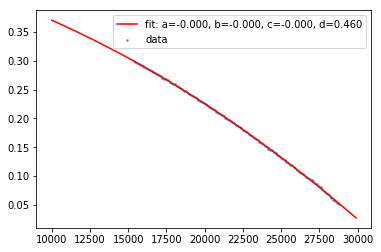

Text(0.5,1,'residuals')

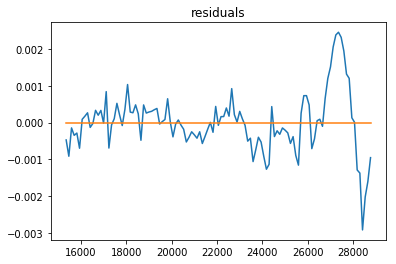

In [25]:
# poly fit

from scipy.optimize import curve_fit

def mypoly(x, a,b,c,d):
    return a*x**3 + b*x**2 + c*x +d



#mask = ~np.isnan(xdata) & ~np.isnan(ydata)
#xdata = xdata[mask]
#ydata = ydata[mask]

plot_x = np.arange(10000,30000,100)

popt, pcov = curve_fit(mypoly, xdata, ydata, p0 = [1,1,1,1])

plt.plot(plot_x, mypoly(plot_x, *popt), 'r-',        
  label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.scatter(xdata,ydata, s=2, alpha=0.8,label="data")
plt.legend()
plt.show()

plt.plot(xdata,ydata-mypoly(xdata,*popt))
plt.plot(xdata,xdata*0)
plt.title("residuals")

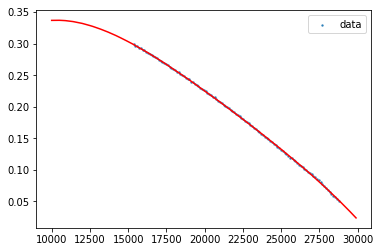

Text(0.5,1,'residuals')

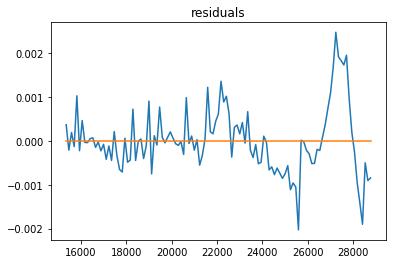

In [22]:
# poly fit

from scipy.optimize import curve_fit

def mypoly(x, a,b,c,d,e,f):
    return a*x**5 + b*x**4 + c*x**3 +d*x**2 +e*x +f



#mask = ~np.isnan(xdata) & ~np.isnan(ydata)
#xdata = xdata[mask]
#ydata = ydata[mask]


popt, pcov = curve_fit(mypoly, xdata, ydata, p0 = [1,1,1,1,1,1])

#plt.plot(plot_x, mypoly(plot_x, *popt), 'r-',        
#  label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.plot(plot_x, mypoly(plot_x, *popt), 'r-')
plt.scatter(xdata,ydata, s=2, alpha=0.8,label="data")
plt.legend()
plt.show()

plt.plot(xdata,ydata-mypoly(xdata,*popt))
plt.plot(xdata,xdata*0)
plt.title("residuals")

In [ ]:

















# deprecated stuff here #

















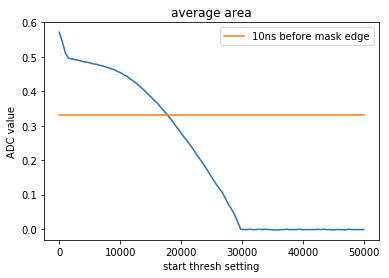

In [90]:
adc_vals = []
thr_vals = []


# goal is to bridge one clock period, i.e. 33.3% of a 3 clock cycle
    

enable_stop(0)
enable_start(1)
enable_mask(1)
set_loop_length(3)
set_mask_time(2)
set_start_time(0)
set_stop_time(0)
set_thr_start(10e3)
set_thr_stop(10e3)

    

for thr_start in np.linspace(0e3,50e3,100):
    set_thr_start(thr_start)
    time.sleep(0.1)
    adc_vals += [read_calib_adc()]
    thr_vals += [int(thr_start)]
    
adc_vals = np.array(adc_vals)
thr_vals = np.array(thr_vals)
    
plt.plot(thr_vals, adc_vals)
plt.plot(thr_vals, thr_vals*0+.33,label="10ns before mask edge")
plt.xlabel("start thresh setting")
plt.ylabel("ADC value")
plt.title("average area")
plt.legend()


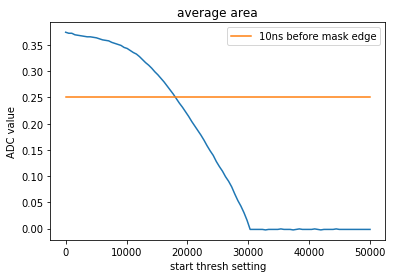

In [88]:
adc_vals = []
thr_vals = []


# goal is to bridge one clock period, i.e. 25% of a 4 clock cycle
# with a thr_start of circa 18000 we reach that
    

enable_stop(0)
enable_start(1)
enable_mask(1)
set_loop_length(4)
set_mask_time(2)
set_start_time(0)
set_stop_time(0)
set_thr_start(10e3)
set_thr_stop(10e3)

    

for thr_start in np.linspace(0e3,50e3,100):
    set_thr_start(thr_start)
    time.sleep(0.1)
    adc_vals += [read_calib_adc()]
    thr_vals += [int(thr_start)]
    
adc_vals = np.array(adc_vals)
thr_vals = np.array(thr_vals)
    
plt.plot(thr_vals, adc_vals)
plt.plot(thr_vals, thr_vals*0+.25,label="10ns before mask edge")
plt.xlabel("start thresh setting")
plt.ylabel("ADC value")
plt.title("average area")
plt.legend()
